# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 

1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook



# ==========================================================
# Задача на МНК (0.4 балла)

In [1]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]
    
"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
σ=0.5

#генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)


def get_params (y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    result = []
    B = np.array([np.sin(t), t, np.ones(m)]).transpose()
    
    if method == 0:
        result = np.dot(np.dot(np.linalg.inv(np.dot(B.transpose(),B)),B.transpose()),y_corr)
    if method == 1:
        result = [0,0,0]
    if method == 2:
        result = [0,0,0]
    return result

get_params(y_corr, t)

array([ 999.97913896,   99.99677084,   10.03185761])

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.7 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.4 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#пример из листочка 1
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])

# A = np.array([[2,3,1],[4,1,2],[3,4,2.0]])
# b= np.array([5, 11, 8])
# c = np.array([5,4,3])

In [118]:
import numpy as np

def pos_val_exists(a):
    for val in a:
        if val > 0:
            return True
    return False


# для правила Бленда
def min_pos_id(a):
    for i in range(len(a)):
        if a[i] > 0:
            return i + 1
        

# лексикографический метод
def choose_lexical(table, n, ent_id):
    for row in table:
        try:
            row = row / row[ent_id]
        except ZeroDivisionError:
            row = row * np.inf
    for i in range(n):
        column = table[:,i]


def check_unbounded(a, b):
    for i in range(len(a)):
        if b[i] != 0:
            if a[i] / b[i] < 0:
                return True
    return False
        

# максимальный из отрицательных из a/b
def get_ent(a, b):
    ent_id = 0
    curr_val = 0
    max_val = 0
    for i in range(len(a)):
        if b[i] != 0:
            if a[i] / b[i] < 0:
                if max_val == 0:
                    curr_val = b[i]
                    ent_id = i
                    max_val = a[i] / b[i]
                if a[i] / b[i] > max_val:
                    curr_val = b[i]
                    ent_id = i
                    max_val = a[i] / b[i]
    return curr_val, ent_id + 1

# для заполнения ячеек симплекс-таблицы
def cross_calc(a, b, c, d):
    return ((-a) * b - c * d) / (-a)


def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <= с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    n = len(c)
    m = len(b)
    
    basic = None
    if start_point is None:
        basic = np.zeros(n)
    else:
        basic = start_point
    nonbasic = b
    
    # точки, найденныйе после каждой итерации, для отрисовки анимации 
    points = [list(basic)]
    
    b.shape = (m,1)
    simplex_table = np.vstack((np.hstack((np.array([0]), c)), np.hstack((b, -A))))
    
    iter_count = 0
    res_val = 0
    res_point = []
    print(simplex_table)
    
    while pos_val_exists(simplex_table[0][1:]):
        ent_id = min_pos_id(simplex_table[0][1:])
        leave_id = 0
        curr_val = 0
        if check_unbounded(simplex_table[:,0][1:], simplex_table[:,ent_id][1:]):
            curr_val, leave_id = get_ent(simplex_table[:,0][1:], simplex_table[:,ent_id][1:])
            
            basic[ent_id - 1] = -(simplex_table[leave_id][0] / simplex_table[leave_id][ent_id])
            points.append(list(basic))
            
            # update simplex-table
            simplex_table[:,ent_id] = simplex_table[:,ent_id] / curr_val
            simplex_table[leave_id] = simplex_table[leave_id] / (-curr_val)
            simplex_table[leave_id][ent_id] = 1 / curr_val
            curr_val = simplex_table[leave_id][ent_id]
            for i in range(m + 1):
                for j in range(n + 1):
                    if i != leave_id and j != ent_id:
                        simplex_table[i][j] = cross_calc(curr_val, simplex_table[i][j],
                                                         simplex_table[leave_id][j], simplex_table[i][ent_id])            
        else:
            return None
        iter_count += 1
        print(simplex_table)
    
    res_val = simplex_table[0][0]
    res_point = basic

    # чтобы рисовал только для двух переменных
    if n != 2:
        draw = False
    
    #тут рисуем анимацию
    if draw:
        fig, ax= plt.subplots(iter_count+1)
        fig.set_figheight(5*(iter_count+1))
        fig.set_figwidth(5)

        for i,a in enumerate(ax):
            # рисуем ограничения
            for j in range(m):
                a.plot([0,b[j]/A[j][0]],[b[j]/A[j][1],0],  color='b')
                grid = np.arange(0, b[j]/A[j][0], 0.01)
                right = (b[j] - A[j][0] * grid) / A[j][1]
                # красим ограничения так, чтобы оласть допустимых значений была самого яркого цвета
                a.fill_between(grid, 0, right, color='red', alpha=0.15)
            a.plot([0,17],[0,0], color='b')
            a.plot([0,0],[0,17], color='b')
            
            # рисуем точки
            a.scatter(points[i][0], points[i][1], color="red")
            
            a.axis([-1, 17, -1, 17])
            
            # подписываем оси и график
            a.set_xlabel('X1')
            a.set_ylabel('X2')
            a.set_title('Iteration %d x=(%.2f, %.2f)' % (i+1,points[i][0],points[i][1]))

        plt.tight_layout()
        plt.show()
        
    return res_point, res_val, iter_count

def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    
    n = len(c)
    m = len(b)
    ids = []
    
    for i in range(m):
        if b[i] == np.sum(np.dot(A[i], x.transpose())):
            ids.append(i)
            
    zeros_count = 0
    for j in x:
        if j == 0:
            zeros_count += 1
            
    if len(ids) + zeros_count < n:
        return False
    return True # (x==np.array([4,0])).all()

[[ 0.   5.   1. ]
 [ 5.  -1.  -2. ]
 [ 8.  -2.  -0.5]]
[[ 20.    -2.5   -0.25]
 [  1.     0.5   -1.75]
 [  4.    -0.5   -0.25]]


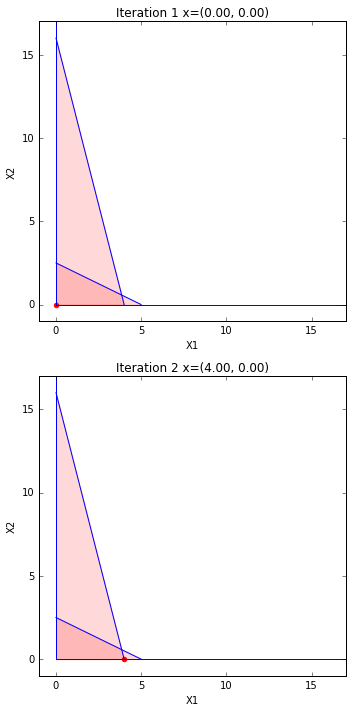

In [119]:
x, best, n_iter = solve_lin_prog(A,b,c, draw=True)
# solve_lin_prog(A,b,c, draw=True)

In [120]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

Точка:  [ 4.  0.]
Ответ:  20.0
Число итераций:  1


In [121]:
is_optimal(A,b,c,x)

True

## Бонус +1 Балл
Напишите программу которая для обоих методов из второй задачи пункта 5 (метод Бланда и лексикографический порядок) будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)